##### Import

In [1]:
import os
import sys
import warnings
import gc
from pathlib import Path

import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### Test on unseen data

In [2]:
from utils import rank_and_quantize

top = 250
DATA_STORE = Path(f'data/total_unseen_data.h5')
key = dataset_key = '/df' # '/data/YEAR_20220906_20230811'
label = 'TARGET_ret_fwd_frac_order_quantiled' # parameters

with pd.HDFStore(DATA_STORE) as store:
    dataset = store[dataset_key]
    dataset = rank_and_quantize(dataset, TARGET_col='TARGET_ret_fwd_frac_order')

# Get unique dates and sort them
unique_dates = dataset.index.get_level_values('date').unique().sort_values()
cols = dataset.columns.tolist()

# Populate the features list with column names starting with 'feature_'
features = [col for col in cols if col.startswith('FEATURE_')]

# Find the first column starting with 'target_' and set it as the label
label_cols = [col for col in cols if col.startswith('TARGET_')]

# Adjust for the look-ahead gap and get test dates
look_ahead = 1
test_dates = unique_dates[-21:]

# Create the test_data DataFrame using cross-section (xs) for MultiIndex slicing
test_data = dataset[dataset.index.isin(test_dates, level='date')]

In [3]:
test_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5334 entries, ('AA', Timestamp('2023-07-14 00:00:00')) to ('ZTS', Timestamp('2023-08-11 00:00:00'))
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_frac_order_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 12.8 MB


In [4]:
import lightgbm as lgb
import pandas as pd

def predict_and_format(model_path: str, test_data: pd.DataFrame, features: list, label: str) -> pd.DataFrame:
    """
    Load a LightGBM model from the specified path, make predictions on the test data, and format the results.

    Parameters:
    - model_path: Path to the saved LightGBM model.
    - test_data: Test dataframe containing features and labels.
    - features: List of feature column names.
    - label: Column name of the label.

    Returns:
    - preds: Formatted dataframe with predictions and selected feature data.
    """

    # Load the model
    best_model = lgb.Booster(model_file=model_path)

    # Extract features and labels
    test_features = test_data[features]
    test_labels = test_data[label]

    # Make predictions
    y_pred = best_model.predict(test_features)

    # Format the predictions dataframe
    preds = test_labels.reset_index(name='actual').assign(predicted=y_pred).set_index(['date', 'ticker'])

    # Rename columns to add 'feature_' prefix
    cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
    new_col_names = ["FEATURE_" + col for col in cols_to_rename]
    rename_dict = dict(zip(cols_to_rename, new_col_names))

    test_data_renamed = test_data.rename(columns=rename_dict)

    # Join with selected feature data
    preds = preds.reset_index().merge(test_data_renamed[new_col_names].reset_index(), 
                                      on=['ticker', 'date'], 
                                      how='left')

    # Filter columns of interest
    preds = preds[['date', 'ticker', 'actual', 'predicted'] + new_col_names].set_index(['ticker', 'date'])
    
    return preds

model_path = "/home/sayem/Desktop/Project/models/_data_YEAR_20130102_20141208_best_model.txt"
preds = predict_and_format(model_path, test_data, features, label)

In [5]:
preds

actual  predicted  FEATURE_open  FEATURE_high  FEATURE_low  \
ticker date                                                                     
AA     2023-07-14    0.25   0.100522     35.500000     35.520000    34.049999   
       2023-07-17    0.00   0.137607     34.349998     36.049999    34.250000   
       2023-07-18    0.00   0.094613     35.310001     35.720001    34.619999   
       2023-07-19    0.00   0.105579     35.169998     35.340000    34.529999   
       2023-07-20    0.00   0.029240     35.330002     35.759998    32.669998   
...                   ...        ...           ...           ...          ...   
ZTS    2023-08-07    0.75   0.734100    180.190002    181.880005   180.029999   
       2023-08-08    0.75   0.786845    182.149994    190.539993   177.250000   
       2023-08-09    0.75   0.813457    189.940002    190.949997   186.964996   
       2023-08-10    0.75   0.779792    190.000000    191.824997   187.729996   
       2023-08-11    0.75   0.786464    188.479996    191.600006   188.179993   

                   FEATURE_close  FEATURE_volume  
ticker date                                       
AA     2023-07-14      34.520000       8082529.0  
       2023-07-17      35.570000       6405879.0  
       2023-07-18      35.040001       4661669.0  
       2023-07-19      34.840000       6127124.0  
       2023-07-20      32.680000      11962060.0  
...                          ...             ...  
ZTS    2023-08-07     180.690002       1941699.0  
       2023-08-08     189.300003       4117986.0  
       2023-08-09     189.350006       2270030.0  
       2023-08-10     189.100006       2348639.0  
       2023-08-11     190.830002       1742931.0  

[5544 rows x 7 columns]

In [6]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [7]:
# Calculate the mean and standard deviation of daily correlations
mean_daily_correlation = daily_correlations.mean()
std_daily_correlation = daily_correlations.std()

# Calculate Sharpe ratio for each date
papermill_era_scores = daily_sharpe_ratios = (daily_correlations - \
    mean_daily_correlation) / std_daily_correlation

papermill_era_scores_df = papermill_era_scores.to_frame()
papermill_era_scores_df.columns = papermill_era_scores_df.columns.astype(str)
sb.glue("papermill_era_scores", papermill_era_scores_df, display=True)

papermill_era_scores_list = papermill_era_scores.tolist()
sb.glue("papermill_era_scores", papermill_era_scores_list)


,0
date,
2023-07-14,0.256884
2023-07-17,0.463050
2023-07-18,0.907629
2023-07-19,-1.334870
2023-07-20,0.798727
2023-07-21,0.293468
2023-07-24,0.157878
2023-07-25,-0.352746
2023-07-26,-0.802956


In [8]:
import matplotlib.pyplot as plt
from pathlib import Path

# Create a list of colors based on the sign of the Sharpe Ratios
colors = ['blue' if value > 0 else 'red' for value in daily_sharpe_ratios]

plt.figure(figsize=(12,6))
daily_sharpe_ratios.plot(kind='bar', color=colors)
plt.title('Daily Sharpe Ratios')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y')
plt.tight_layout()
plt.axhline(y=0, color='black', linestyle='-')  # Add horizontal line at y=0
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Define directory and clean up the dataset_key
plot_dir = Path("plots")
clean_dataset_key = dataset_key.replace("/", "_")

# Create the plots directory if it doesn't exist
plot_dir.mkdir(exist_ok=True)

# Define the save path for the plot using the cleaned key
plot_path = plot_dir / f"sharpe_ratios_{clean_dataset_key}.png"

# Save the plot
plt.savefig(plot_path)
plt.close()

# Convert the path to string and glue it
papermill_plot_path_str = str(plot_path)
sb.glue("papermill_plot_path", papermill_plot_path_str, display=True)

'plots/sharpe_ratios__df.png'

In [9]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

Information Coefficient (overall): 96.123% (p-value: 0.00000000%)


0.9612289752164657

0.0

In [10]:
preds.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5544 entries, ('AA', Timestamp('2023-07-14 00:00:00')) to ('ZTS', Timestamp('2023-08-11 00:00:00'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          5544 non-null   float64
 1   predicted       5544 non-null   float64
 2   FEATURE_open    5544 non-null   float32
 3   FEATURE_high    5544 non-null   float32
 4   FEATURE_low     5544 non-null   float32
 5   FEATURE_close   5544 non-null   float32
 6   FEATURE_volume  5544 non-null   float64
dtypes: float32(4), float64(3)
memory usage: 243.7+ KB


In [11]:
def add_quantile_signals(df, buy_threshold=0.95, sell_threshold=0.05):
    buy_cutoff = df['predicted'].quantile(buy_threshold)
    sell_cutoff = df['predicted'].quantile(sell_threshold)
    
    df['signal'] = 0  # Neutral by default
    df.loc[df['predicted'] >= buy_cutoff, 'signal'] = 1  # Buy
    df.loc[df['predicted'] <= sell_cutoff, 'signal'] = -1  # Sell
    return df

# Apply the function
preds = add_quantile_signals(preds, \
    buy_threshold=0.95, sell_threshold=0.05)

In [12]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5544 entries, ('AA', Timestamp('2023-07-14 00:00:00')) to ('ZTS', Timestamp('2023-08-11 00:00:00'))
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          5544 non-null   float64
 1   predicted       5544 non-null   float64
 2   FEATURE_open    5544 non-null   float32
 3   FEATURE_high    5544 non-null   float32
 4   FEATURE_low     5544 non-null   float32
 5   FEATURE_close   5544 non-null   float32
 6   FEATURE_volume  5544 non-null   float64
 7   signal          5544 non-null   int64  
dtypes: float32(4), float64(3), int64(1)
memory usage: 287.0+ KB


##### Backtesting

In [13]:
# import pandas as pd
# import backtrader as bt
# import backtrader.analyzers as btanalyzers
# from pypfopt import EfficientFrontier, expected_returns, risk_models
# import pyfolio as pf

# class PandasPredictions(bt.feeds.PandasData):
#     lines = ('signal',)
#     params = (
#         ('signal', -1),
#         ('open', 'FEATURE_open'),
#         ('high', 'FEATURE_high'),
#         ('low', 'FEATURE_low'),
#         ('close', 'FEATURE_close'),
#         ('volume', 'FEATURE_volume')
#     )

# def optimize_weights(datas):
#     prices = {}
    
#     for data in datas:
#         # Convert data to pandas series and name it
#         s = pd.Series(data.close.array, index=data.datetime.array, name=data._name)
#         prices[data._name] = s

#     # Create a DataFrame with a common date index
#     df = pd.DataFrame(index=prices[next(iter(prices))].index)

#     for ticker, s in prices.items():
#         df = df.merge(s, left_index=True, right_index=True, how='left').rename(columns={s.name: ticker})

#     # Handle missing data (can use forward fill, backward fill, or drop NaN, depending on your needs)
#     df = df.dropna()  # For this example, I'll drop rows with missing data

#     mu = expected_returns.mean_historical_return(df)
#     # print(mu)
#     S = risk_models.sample_cov(df)
#     # ef = EfficientFrontier(mu, S, solver="ECOS")
#     ef = EfficientFrontier(mu, S, solver="SCS", verbose=True)
#     weights = ef.max_sharpe(risk_free_rate=0.005)  # example with 0.5% risk-free rate
#     return ef.clean_weights()


# class TradeAndRebalanceStrategy(bt.Strategy):
#     def __init__(self):
#         self.rebalance_days = 0
#         self.max_loss = -0.15
#         self.start_cash = self.broker.get_cash()
#         self.benchmark = self.getdatabyname("S&P 500")  # reference to the S&P 500 data

#     def next(self):
#         if (self.broker.get_cash() - self.start_cash) / self.start_cash <= self.max_loss:
#             return
        
#         # Trading signals based on existing signal column in preds dataframe
#         for data in self.datas:
#             if data._name == "S&P 500":  # Skip the benchmark data
#                 continue
#             if data.signal[0] == 1:
#                 self.buy(data)
#             elif data.signal[0] == -1:
#                 self.sell(data)

#         # Rebalancing
#         if self.rebalance_days == 0:
#             weights = optimize_weights([data for data in self.datas if data._name != "S&P 500"])  # Exclude benchmark from optimization
#             for asset, weight in weights.items():
#                 if weight > 0.30:
#                     weights[asset] = 0.30
            
#             for data in self.datas:
#                 if data._name == "S&P 500":  # Skip the benchmark data
#                     continue
#                 if data._name in weights:
#                     self.order_target_percent(data, target=weights[data._name])
#                 else:
#                     self.close(data)
#             self.rebalance_days = 20
#         else:
#             self.rebalance_days -= 1

#         # Log benchmark performance
#         benchmark_return = (self.benchmark.close[0] - self.benchmark.close[-1]) / self.benchmark.close[-1]
#         self.log(f"Benchmark Return: {benchmark_return * 100:.2f}%")

[*********************100%***********************]  1 of 1 completed
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 28 09:59:18 AM: Your problem has 251 variables, 5 constraints, and 0 parameters.
(CVXPY) Sep 28 09:59:18 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 28 09:59:18 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 28 09:59:18 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 28 09:59:18 AM: Compiling problem (target solver=SCS).
(CVXPY) Sep 28 09:59:18 AM:

Start date,2023-07-14
End date,2023-08-11
Total months,1
,Backtest
Annual return,35.1%
Cumulative returns,2.5%
Annual volatility,23.9%
Sharpe ratio,1.37
Calmar ratio,6.99
Stability,0.22
Max drawdown,-5.0%


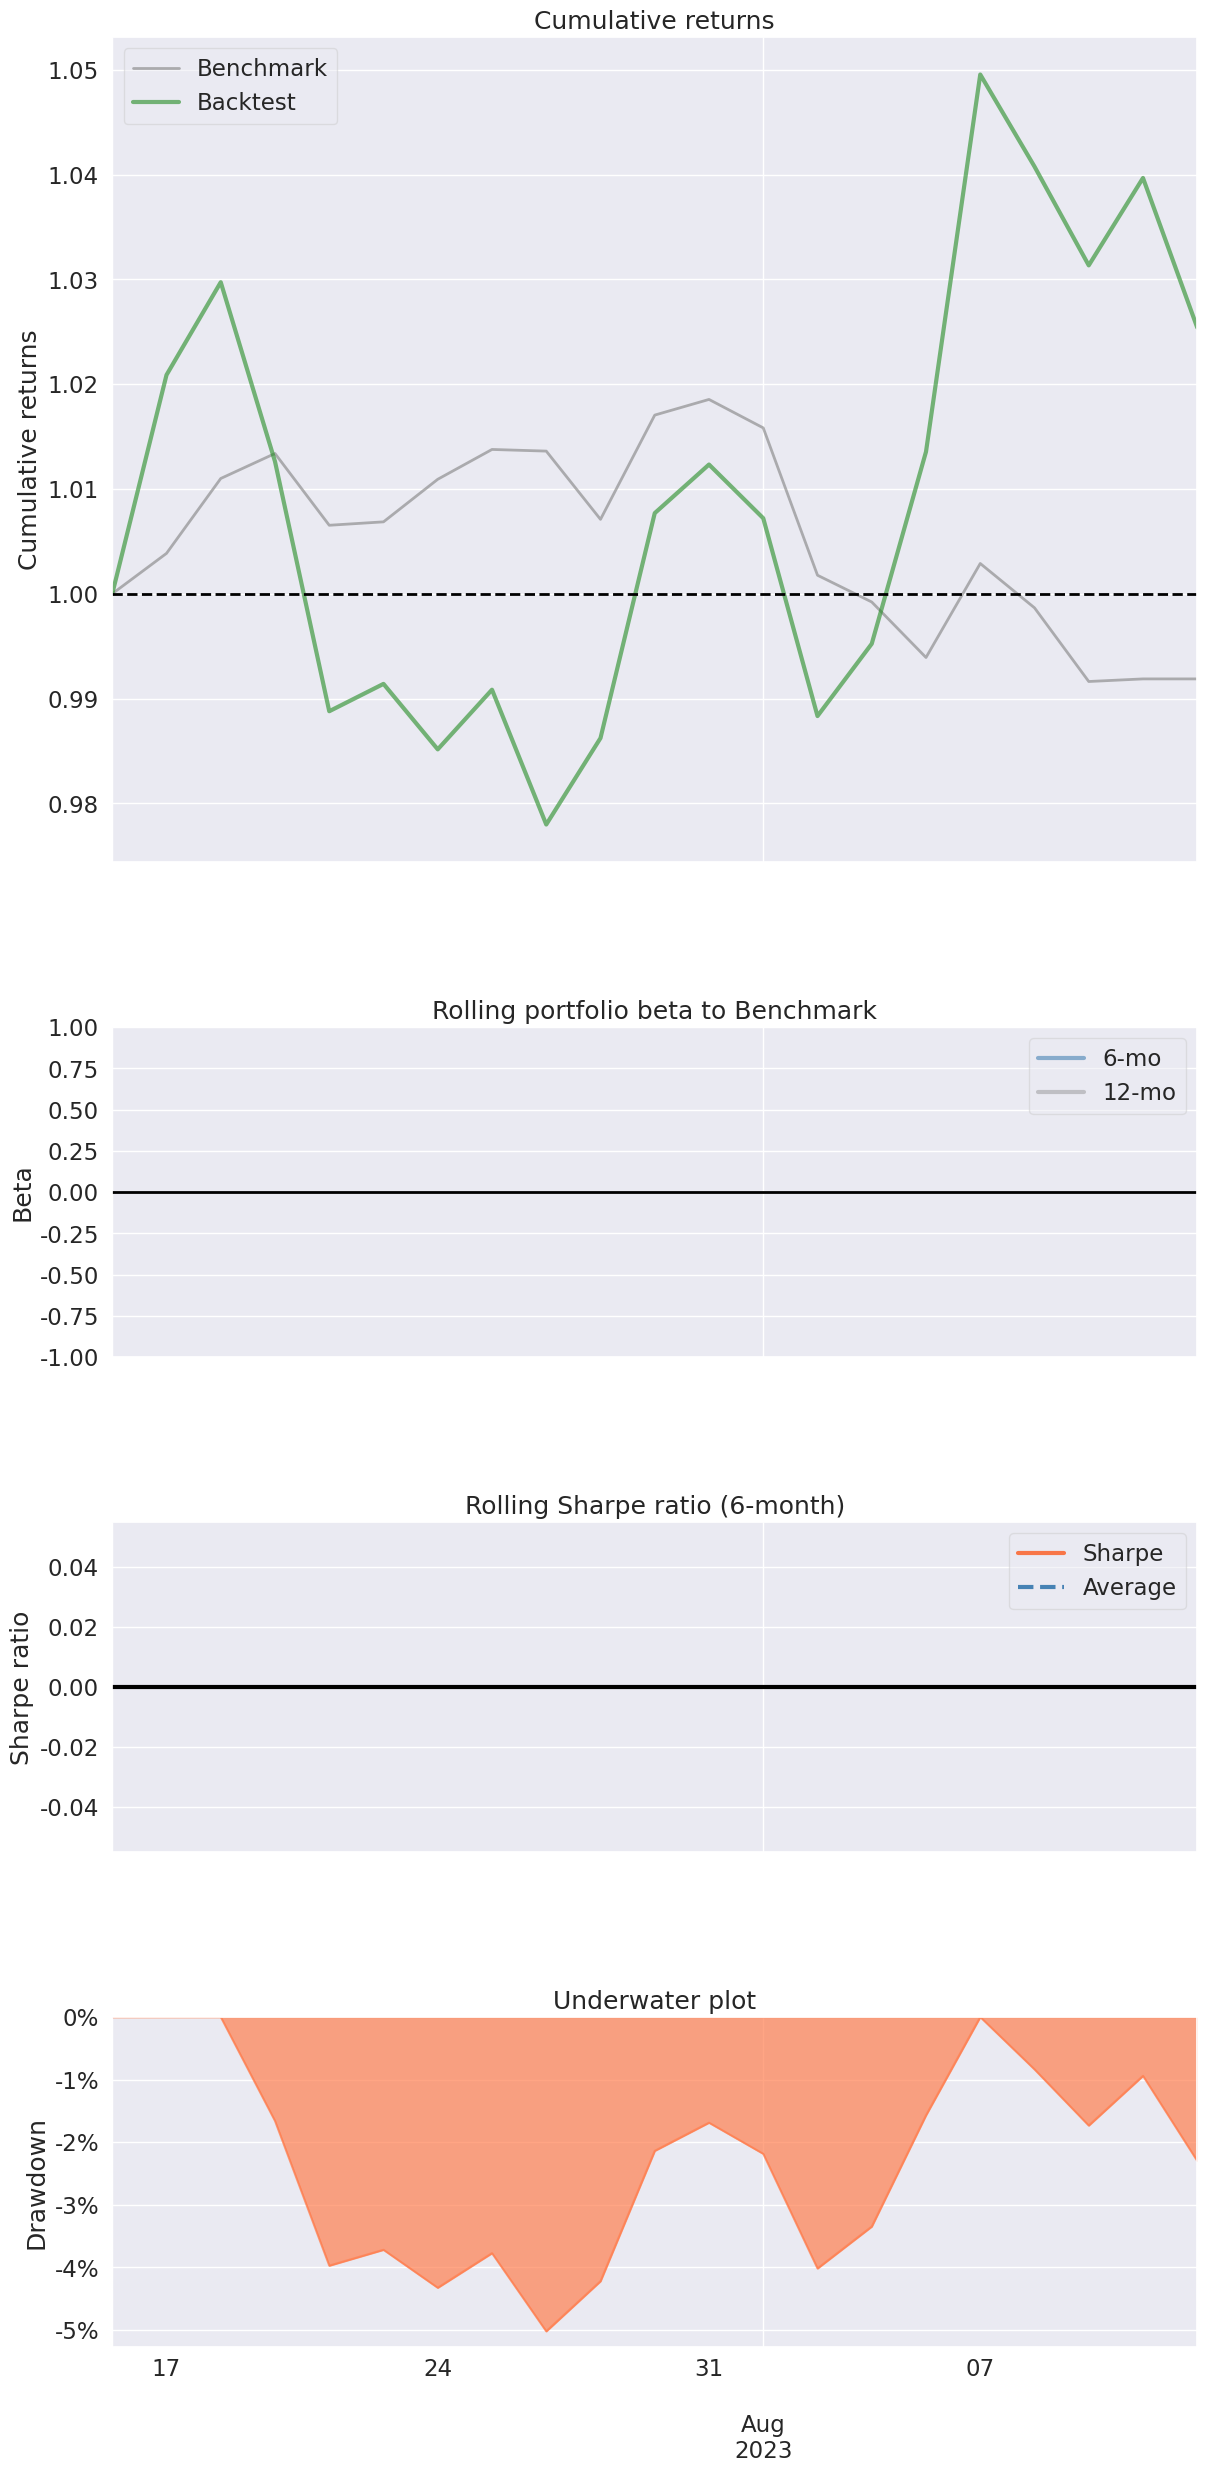

In [14]:
import pandas as pd
import backtrader as bt
import backtrader.analyzers as btanalyzers
from pypfopt import EfficientFrontier, expected_returns, risk_models
import pyfolio as pf
import yfinance as yf

# Data Class for Predictions
class PandasPredictions(bt.feeds.PandasData):
    lines = ('signal',)
    params = (
        ('signal', -1),
        ('open', 'FEATURE_open'),
        ('high', 'FEATURE_high'),
        ('low', 'FEATURE_low'),
        ('close', 'FEATURE_close'),
        ('volume', 'FEATURE_volume')
    )

# Function to optimize weights using PyPortfolioOpt
def optimize_weights(datas):
    prices = {}
    
    for data in datas:
        s = pd.Series(data.close.array, index=data.datetime.array, name=data._name)
        prices[data._name] = s

    df = pd.DataFrame(index=prices[next(iter(prices))].index)

    for ticker, s in prices.items():
        df = df.merge(s, left_index=True, right_index=True, how='left').rename(columns={s.name: ticker})

    df = df.dropna()

    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)
    ef = EfficientFrontier(mu, S, solver="SCS", verbose=True)
    weights = ef.max_sharpe(risk_free_rate=0.005)
    return ef.clean_weights()

# Strategy Class
class TradeAndRebalanceStrategy(bt.Strategy):
    lines = ('benchmark',)  # Added benchmark line here
    
    def __init__(self):
        self.rebalance_days = 0
        self.max_loss = -0.15
        self.start_cash = self.broker.get_cash()
        self.benchmark_data = self.getdatabyname("S&P 500")

    def log(self, txt, dt=None):
        ''' Logging function for the strategy. It logs the date and the message provided. '''
        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt.isoformat()}, {txt}")

    def next(self):
        # Update benchmark line at each step
        self.lines.benchmark[0] = self.benchmark_data.close[0] 

        if (self.broker.get_cash() - self.start_cash) / self.start_cash <= self.max_loss:
            return
        
        for data in self.datas:
            if data._name == "S&P 500":  # Skip the benchmark
                continue
            if data.signal[0] == 1:
                self.buy(data)
            elif data.signal[0] == -1:
                self.sell(data)

        if self.rebalance_days == 0:
            weights = optimize_weights([data for data in self.datas if data._name != "S&P 500"])
            for asset, weight in weights.items():
                if weight > 0.30:
                    weights[asset] = 0.30
            
            for data in self.datas:
                if data._name == "S&P 500":
                    continue
                if data._name in weights:
                    self.order_target_percent(data, target=weights[data._name])
                else:
                    self.close(data)
            self.rebalance_days = 20
        else:
            self.rebalance_days -= 1

        benchmark_return = (self.benchmark_data.close[0] - self.benchmark_data.close[-1]) / self.benchmark_data.close[-1]
        self.log(f"Benchmark Return: {benchmark_return * 100:.2f}%")

# Fetch S&P 500 data using yfinance
def fetch_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df

# Assume preds is defined somewhere earlier in your code
start_date = preds.index.get_level_values(1).min()
end_date = preds.index.get_level_values(1).max()
sp500_data = fetch_data('^GSPC', start_date, end_date)

# Convert it into Backtrader format
benchmark = bt.feeds.PandasData(dataname=sp500_data, name="S&P 500")

cerebro = bt.Cerebro()
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(btanalyzers.PyFolio, _name='pyfolio')
cerebro.adddata(benchmark)

your_data_dict = {ticker: preds.xs(ticker) for ticker in preds.index.get_level_values(0).unique()}
for ticker, data_df in your_data_dict.items():
    data = PandasPredictions(dataname=data_df, name=ticker)
    cerebro.adddata(data)

cerebro.addstrategy(TradeAndRebalanceStrategy)
results = cerebro.run()

# Performance Analysis
returns, positions, transactions, gross_lev \
    = results[0].analyzers.pyfolio.get_pf_items()

# Calculate benchmark returns and add to returns DataFrame
benchmark_rets = sp500_data['Adj Close'].pct_change().dropna()
benchmark_rets.index = benchmark_rets.index.tz_localize(None)  # Remove timezone info
returns.index = returns.index.tz_localize(None)  # Ensure the strategy returns index is also tz-naive
returns = pd.concat([returns, benchmark_rets], axis=1)
returns.columns = ['Strategy', 'Benchmark']

# Pass benchmark_rets to create_full_tear_sheet
pf.create_simple_tear_sheet(returns['Strategy'], benchmark_rets=returns['Benchmark'])